# (ZIP Code 1) A Small Digit Recognition Problem
Reproducing Yan LeCun http://yann.lecun.com/exdb/publis/pdf/lecun-89.pdf

The database is composed of 480 examples of numerals represented as 16 pixel by 16 pixel binary images. 12 example of each of the 10 digits were hand-drawn by a single person on a 16 by 13 bitmap using a mouse. Each image was then used to generate 4 examples by putting the original image in 4 consecutive horizontal positions on a 16 by 16 bitmap. The training set was then formed by choosing 32 examples of each class at random amoung the complete set of 480 images. The remaining 16 examples of each class were used as the test set. Thus the training set contained 320 images, and the test set contained 160 images.

## Load and Prepare Data
The images originally used by LeCun are not available now, so I've drawn them myself. It is stored in bmp file.

In [1]:
import numpy as np
from PIL import Image
from matplotlib import transforms, pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

%matplotlib inline

# define plots common properties and color constants
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
GRAY1, GRAY4, GRAY7 = '#231F20', '#646369', '#929497'

In [2]:
# load monochrome bmp file and convert it to int numpy array
img = np.array(Image.open('../data/numerals.bmp')).astype(int)

In [3]:
# construct 480 16x16 examples with only one channel (usually 3 for RGB)
X = np.zeros(shape=(480, 16, 16, 1))
y = np.zeros(shape=(480, 1))
example_idx = 0
for i in range(10):
    for j in range(12):
        # crop 16x13 patch from the data image
        # one pixel is between numerals,  so multipy on 17 and 14
        si, fi = i*17, i*17+16
        sj, fj = j*14, j*14+13
        patch = 1-img[si:fi, sj:fj]
        # shift patch to get 4 examples from one
        for k in range(4):
            X[example_idx, 0:16, k:k+13, 0] = patch
            y[example_idx, 0] = i
            example_idx += 1

In [4]:
# perform a stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=320, random_state=10, stratify=y)
# convert classes to one-hot vectors
ohe = OneHotEncoder(categories='auto').fit(y)
Y_train = ohe.transform(y_train).toarray()
Y_test = ohe.transform(y_test).toarray()

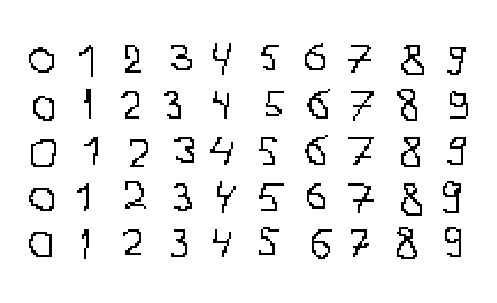

In [5]:
# some training examples
w = 20  # pixels for one digit
result = np.zeros(shape=(4+w*5, 4+w*10))
for d in range(10):
    d_idx = np.squeeze(np.argwhere(y_train == d))[:, 0]
    d_idx = np.random.choice(d_idx, 5, replace=False)
    for i, idx in enumerate(d_idx):
        result[i*w+4:i*w+20, d*w+4:d*w+20] = -X_train[idx].reshape((16, 16))
fig, ax = plt.subplots(figsize=(5.5, 3.3), dpi=110)
ax.imshow(result, cmap="gray")
ax.set_aspect('equal', 'datalim')
ax.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
for spine in ax.spines.values():
    spine.set_visible(False)

## Training

In [6]:
from sklearn.metrics import accuracy_score
import os
# don't use GPU
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
import tensorflow as tf

In [7]:
# all nets will use the same loss function and the optimization step
def build_optimizer_step(learning_rate, y_true, y_hat):
    cross_entropy = y_true*tf.log(y_hat)
    loss = tf.reduce_mean(-tf.reduce_sum(cross_entropy, reduction_indices=1))
    opt = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    return opt

In [8]:
# this training procedure will be used for all nets
def train(session, x_tensor, y_tensor, y_hat_tensor, lr, n_epochs):
    accuracy = []
    optimizer_step = build_optimizer_step(lr, y_tensor, y_hat_tensor)
    session.run(tf.global_variables_initializer())
    for e in range(n_epochs):
        for b in range(X_train.shape[0]):
            # give images to the optimizer one by one
            fd_train = {x_tensor: X_train[b:b+1], y_tensor: Y_train[b:b+1]}
            session.run(optimizer_step, fd_train)
        # calculate test accuracy after each epoch
        fd_test = {x_tensor: X_test}
        y_test_hat = np.argmax(session.run(y_hat_tensor, fd_test), axis=1)
        accuracy.append(accuracy_score(y_test, y_test_hat))
    return accuracy

In [9]:
# start tensorflow session
session = tf.Session()

# define placeholders for features and targets
x = tf.placeholder(tf.float32, shape=[None, 16, 16, 1])
y = tf.placeholder(tf.float32, shape=[None, 10])

## Net-1
No hidden layer, equivalent to multinomial logistic regression.

In [10]:
# use xavier initializer for weights' starting values
initializer = tf.contrib.layers.xavier_initializer(seed=1)

# parameters
A = tf.Variable(initializer([256, 10]))
a0 = tf.Variable(initializer([1, 10]))
# number of trainable parameters calculation
parms = [A, a0]
size = tf.reduce_sum([tf.size(p) for p in parms])

# neural network computation graph
x_flatten = tf.reshape(x, [-1, 256])
y_hat = tf.nn.softmax(a0 + x_flatten@A)

# train
net1_size = session.run(size)
net1_accuracy = train(session, x, y, y_hat, 7e-3, 30)

## Net-2
One hidden layer, 12 hidden units fully connected.

In [11]:
# use xavier initializer for weights' starting values
initializer = tf.contrib.layers.xavier_initializer(seed=1)

# parameters
n_hidden = 12
A = tf.Variable(initializer([256, n_hidden]))
a0 = tf.Variable(initializer([1, n_hidden]))
B = tf.Variable(initializer([n_hidden, 10]))
b0 = tf.Variable(initializer([10]))
# number of trainable parameters calculation
parms = [A, a0, B, b0]
size = tf.reduce_sum([tf.size(p) for p in parms])

# neural network computation graph
x_flatten = tf.reshape(x, [-1, 256])
Z = tf.nn.tanh(a0 + x_flatten@A)
y_hat = tf.nn.softmax(b0 + Z@B)

# train
net2_size = session.run(size)
net2_accuracy = train(session, x, y, y_hat, 7e-3, 30)

## Net-3
Two hidden layers locally connected.

In [12]:
# use xavier initializer for weights' starting values
initializer = tf.contrib.layers.xavier_initializer(seed=1)

# parameters
A = tf.Variable(initializer([1, 8, 8, 9]))
a0 = tf.Variable(initializer([1, 8, 8]))
B = tf.Variable(initializer([1, 4, 4, 25]))
b0 = tf.Variable(initializer([1, 4, 4]))
C = tf.Variable(initializer([16, 10]))
c0 = tf.Variable(initializer([10]))
# number of trainable parameters calculation
parms = [A, a0, B, b0, C, c0]
size = tf.reduce_sum([tf.size(p) for p in parms])

# neural network computation graph
patches1 = tf.extract_image_patches(
    images=x,
    ksizes=[1, 3, 3, 1],
    strides=[1, 2, 2, 1],
    rates=[1, 1, 1, 1],
    padding='SAME'
)
Z1 = tf.expand_dims(tf.nn.tanh(tf.reduce_sum(patches1 * A, axis=3)+a0), -1)

patches2 = tf.extract_image_patches(
    images=Z1,
    ksizes=[1, 5, 5, 1],
    strides=[1, 1, 1, 1],
    rates=[1, 1, 1, 1],
    padding='VALID'
)
Z2 = tf.reshape(
    tf.nn.tanh(tf.reduce_sum(patches2 * B, axis=3)+b0),
    [-1, 16])
y_hat = tf.nn.softmax(c0 + Z2@C)

# train
net3_size = session.run(size)
net3_accuracy = train(session, x, y, y_hat, 7e-3, 30)

## Net-4
Two hidden layers, locally connected with weight sharing.

In [13]:
# use xavier initializer for weights' starting values
initializer = tf.contrib.layers.xavier_initializer(seed=1)

# parameters
A = tf.Variable(initializer([3, 3, 1, 2]))
a0 = tf.Variable(initializer([1, 8, 8, 2]))
B = tf.Variable(initializer([1, 4, 4, 50]))
b0 = tf.Variable(initializer([1, 4, 4]))
C = tf.Variable(initializer([16, 10]))
c0 = tf.Variable(initializer([10]))
# number of trainable parameters calculation
parms = [A, a0, B, b0, C, c0]
size = tf.reduce_sum([tf.size(p) for p in parms])

# neural network computation graph
Z1 = tf.nn.tanh(
    tf.nn.conv2d(
        input=x,
        filter=A,
        strides=[1, 2, 2, 1],
        padding='SAME'
    ) + a0)

patches = tf.extract_image_patches(
    images=Z1,
    ksizes=[1, 5, 5, 1],
    strides=[1, 1, 1, 1],
    rates=[1, 1, 1, 1],
    padding='VALID'
)
Z2 = tf.reshape(tf.nn.tanh(tf.reduce_sum(patches*B, axis=3)+b0), [-1, 16])
y_hat = tf.nn.softmax(c0 + Z2@C)

# train
net4_size = session.run(size)
net4_accuracy = train(session, x, y, y_hat, 7e-3, 30)

## Net-5
Two hidden layers, locally connected, two levels of weight sharing.

In [19]:
# use xavier initializer for weights' starting values
initializer = tf.contrib.layers.xavier_initializer(seed=20)

# parameters
A = tf.Variable(initializer([3, 3, 1, 2]))
a0 = tf.Variable(initializer([1, 8, 8, 2]))
B = tf.Variable(initializer([5, 5, 2, 4]))
b0 = tf.Variable(initializer([1, 4, 4, 4]))
C = tf.Variable(initializer([64, 10]))
c0 = tf.Variable(initializer([10]))
# number of trainable parameters calculation
parms = [A, a0, B, b0, C, c0]
size = tf.reduce_sum([tf.size(p) for p in parms])

# neural network computation graph
Z1 = tf.nn.tanh(
    tf.nn.conv2d(
        input=x,
        filter=A,
        strides=[1, 2, 2, 1],
        padding='SAME'
    ) + a0)

Z2 = tf.reshape(
    tf.nn.tanh(
        tf.nn.conv2d(
            input=Z1,
            filter=B,
            strides=[1, 1, 1, 1],
            padding='VALID') + b0),
    [-1, 64])
y_hat = tf.nn.softmax(c0 + Z2@C)

# train
net5_size = session.run(size)
net5_accuracy = train(session, x, y, y_hat, 7e-3, 30)

In [20]:
architectures = [
    'Net-1: Single layer network',
    'Net-2: Two layer network',
    'Net-3: Locally connected',
    'Net-4: Constrained network 1',
    'Net-5: Constrained network 2']
sizes = [net1_size, net2_size, net3_size, net4_size, net5_size]
test_scores = [net1_accuracy, net2_accuracy, net3_accuracy,
               net4_accuracy, net5_accuracy]
best_scores = [max(score) for score in test_scores]

for n, s, b in zip(architectures, sizes, best_scores):
    print(f'{n:<30} {s:>10} {100*b:>10.1f}%')

Net-1: Single layer network          2570       91.9%
Net-2: Two layer network             3214       94.4%
Net-3: Locally connected             1226       94.4%
Net-4: Constrained network 1         1132       96.9%
Net-5: Constrained network 2         1060       98.8%


0.91875 0.94375 0.94375 0.96875 0.9875


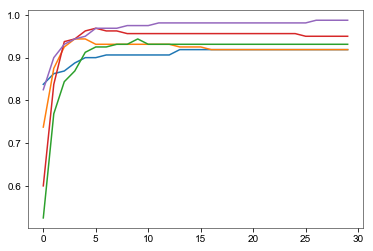

In [21]:
plt.plot(range(30), net1_accuracy)
plt.plot(range(30), net2_accuracy)
plt.plot(range(30), net3_accuracy)
plt.plot(range(30), net4_accuracy)
plt.plot(range(30), net5_accuracy)
print(max(net1_accuracy), max(net2_accuracy), max(net3_accuracy), max(net4_accuracy), max(net5_accuracy))

# (ZIP Code 2)
Normalized handwritten digits, automatically scanned from envelopes by the U.S. Postal Service. The original scanned digits are binary and of different sizes and orientations; the images here have been deslanted and size normalized, resulting in 16 x 16 grayscale images (Le Cun et al., 1990).

The data is in a numpy compressed file, and each row consists of the digit id (0-9) followed by the 256 grayscale values. The last column contains is_test flag 0 for train and 1 for test observations.

There are 7291 training observations and 2007 test observations.

The test set is notoriously "difficult", and a 2.5% error rate is excellent. These data were kindly made available by the neural network group at AT&T research labs (thanks to Yann Le Cunn).

http://yann.lecun.com/exdb/publis/pdf/lecun-89.pdf

http://yann.lecun.com/exdb/publis/pdf/lecun-89e.pdf

http://yann.lecun.com/exdb/publis/pdf/lecun-99.pdf

In [1]:
import pandas as pd
from matplotlib import transforms, pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np

%matplotlib inline

# define plots common properties and color constants
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
GRAY1, GRAY4, GRAY7 = '#231F20', '#646369', '#929497'

## Load and Prepare Data

In [2]:
# PAGE 404. Figure 11.9 shows some examples of normalized handwritten digits,
#           automatically scanned from envelopes by the U.S. Postal Service.
#           The original scanned digits are binary and of different sizes and
#           orientations; the images shown here have been deslanted and size
#           normalized, resulting in 16× 16 grayscale images (Le Cun et al.,
#           1990). These 256 pixel values are used as inputs to the neural
#           network classifier.

# load numpy array from the compressed file
arr = np.load('../data/zip.npy.npz')['arr_0']
# do train-test split by the last column
train, test = arr[arr[:, -1] == 0], arr[arr[:, -1] == 1]
X_train, X_test = train[:, 1:-1], test[:, 1:-1]
y_train, y_test = train[:, 0].astype(int), test[:, 0].astype(int)

# do one hot labels encoding
ohe = OneHotEncoder(categories='auto')
Y_train_one_hot = ohe.fit_transform(y_train.reshape(-1, 1)).toarray()
Y_test_one_hot = ohe.fit_transform(y_test.reshape(-1, 1)).toarray()

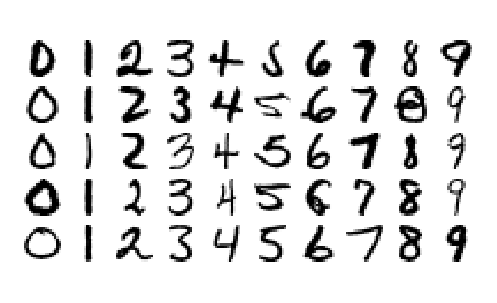

In [3]:
# PAGE 404. FIGURE 11.9. Examples of training cases from ZIP code data. Each
#           image is a 16 × 16 8-bit grayscale representation of a handwritten
#           digit.
w = 20  # pixels for one digit
result = np.ones(shape=(4+w*5, 4+w*10))
for d in range(10):
    d_idx = np.squeeze(np.argwhere(y_train == d))
    d_idx = np.random.choice(d_idx, 5, replace=False)
    for i, idx in enumerate(d_idx):
        result[i*w+4:i*w+20, d*w+4:d*w+20] = -X_train[idx].reshape((16, 16))
fig, ax = plt.subplots(figsize=(5.5, 3.3), dpi=110)
ax.imshow(result, cmap="gray")
ax.set_aspect('equal', 'datalim')
ax.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
for spine in ax.spines.values():
    spine.set_visible(False)